# Software profesional en Acústica 2020-21 (M2i)

*This notebook contains an modified excerpt from Section 24.3 in the [Python Programming and Numerical Methods - A Guide for Engineers and Scientists](https://www.elsevier.com/books/python-programming-and-numerical-methods/kong/978-0-12-819549-9), the content is also available at [Berkeley Python Numerical Methods](https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html).The copyright of the book belongs to Elsevier. We also have this interactive book online for a better learning experience. The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Computation of the Fast Fourier Transform (FFT)

Usually, any time signal $f(t)$ contains a lot of frequencies involved in their definition: this is the intuitive origin of the Discrete Fourier Transform. In that manner, any periodic (real or complex-valued) funcion $f(t)$ in $[0,T]$ can be approximated by a linear combination of $n+1$ (assumed even by simplicity) oscillatory functions (sine and cosine functions at different angular frequency)
$$
f(t)\approx \sum_{j=-n/2}^{n/2}F_{j}e^{i\omega_{j}t}
$$
where $F_{j}$ are the so-called Fourier amplitudes and the Fourier modes $e^{i\omega_{j}t}=\cos(\omega_{j}t)+i\cos(\omega_{j}t)$ are determined by its associated angular frequency $\omega_{j}$ given by
$$
\omega_{j}=\frac{2\pi j}{NT}\qquad j=-n/2,\ldots,n/2.
$$

The computation of the vector $(F_{-n/2},\ldots,F_{n/2})$ is a high-expensive computational task if standard dense linear algebra is used. However, in Python, there are very mature FFT functions both in *NumPy* and *SciPy*. In this section, we will take a look of both packages and see how we can easily use them in our work. Let's first generate the signal as before. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

Let's start with a general time-signal $f(t)$ given by
$$
f(t)=3\sin(2\pi t)+\sin(8\pi t)+0.5\sin(14\pi t).
$$

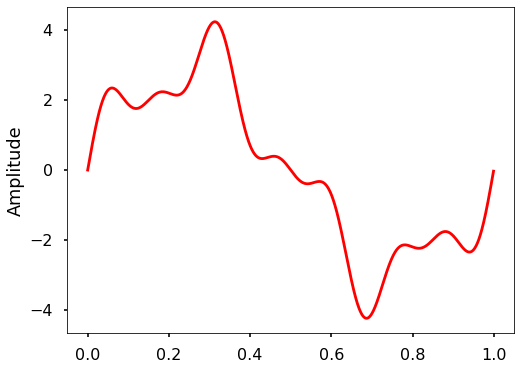

array([0.000e+00, 5.000e-04, 1.000e-03, ..., 9.985e-01, 9.990e-01,
       9.995e-01])

In [54]:
# sampling rate
sr = 2000
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
f = 3*np.sin(2*np.pi*freq*t)

freq = 4
f += np.sin(2*np.pi*freq*t)

freq = 7   
f += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, f, 'r')
plt.ylabel('Amplitude')

plt.show()
t

## FFT in NumPy or SciPy

**EXAMPLE:** Use *fft* and _ifft_ function from *NumPy* or *SciPy* to calculate the FFT amplitude spectrum and inverse FFT to obtain the original signal. Plot both results. Time the _fft_ function using this 2000 length signal. 

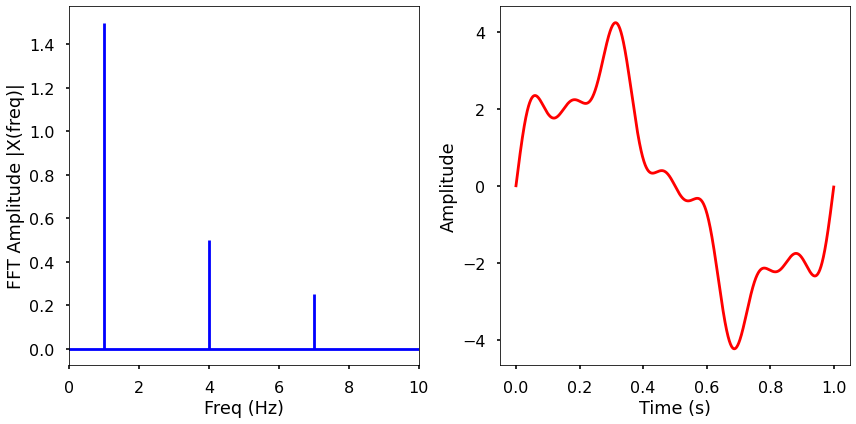

In [3]:
# from numpy.fft import fft, ifft # equivalently to
from scipy.fftpack import fft, ifft, fftfreq
# Compute FFT
F = fft(f)
# Compute the frequency associated with the Fourier modes
freq = fftfreq(len(f), d=ts)

# Plot
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(F)/len(F), 'b', markerfmt=" ", basefmt="-b", use_line_collection=True)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)# only positive frequencies are plotted

plt.subplot(122)
plt.plot(t, np.real(ifft(F)), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Solving the Helmholtz equation with periodic boundary conditions

Solve the Helmholtz problem using the finite element method, and plot the numerical approximation. The ODE is
$$ -\frac{d^2u}{dx^2} - k^2u = f$$
with periodic boundary conditions $u(0)=u(L) $ and source term $f(x)=1$. So, the unknown $u$ and the source term $f$ are considered $L$-periodic. For simplicity, let's take $L=1$.

Since we are going to apply the Discrete Fourier Transform on $u(x)$, now the Fourier approximation reads
$$
u(x)\approx u_{n}(x)=\sum_{j=-n/2}^{n/2}U_{j}e^{ik_{j}x}
$$
where $U_{j}$ are the so-called Fourier amplitudes and the Fourier modes $e^{ik_{j}x}=\cos(k_{j}x)+i\cos(k_{j}x)$ are determined by its associated wavenumber $k_{j}$ given by
$$
k_{j}=\frac{2\pi j}{NL}\qquad j=-n/2,\ldots,n/2.
$$
Analogous considerations are made for $f(x)$. In that manner,
$$
f(x)\approx \sum_{j=-n/2}^{n/2}F_{j}e^{ik_{j}x}.
$$
Consequently, the Fourier discretization of the Helmholtz problem can be writen as
$$
\sum_{j=-n/2}^{n/2}k_{j}^{2}U_{j}e^{ik_{j}x}-k^2\sum_{j=-n/2}^{n/2}U_{j}e^{ik_{j}x}=\sum_{j=-n/2}^{n/2}F_{j}e^{ik_{j}x}.
$$
Since each Fourier mode is orthogonal in $L^2(0,L)$, then the equation above should be satisfied for each term of the Fourier expansion independently. Hence, it holds
$$
(k_{j}^{2}-k^2)U_{j}=F_{j}\qquad j=-n/2,\ldots,n/2,
$$
if $k\ne k_{j}$ for all $j=-n/2,\ldots,n/2$ (otherwise the discrete linear system is not well-posed)
and then 
$$
u_{n}(x)=\sum_{j=-n/2}^{n/2}\frac{F_{j}}{k_{j}^{2}-k^2}e^{ik_{j}x}.
$$
The implementation of this Fourier discretization is immediate using ``fft`` and ``ifft`` and it does not require the solution of a dense (or sparse) linear system of equations, since the Discrete Fourier Transform diagonalize the differential operators involved in the Helmhotz problem.

In [70]:
def compute_fft(L, k, f_source, n):

    # Collocation grid
    xs = L/n
    x = np.arange(0,L,xs)
    # Compute FFT
    F = fft(f_source(x))
    # Compute the frequency associated with the Fourier modes
    freq = fftfreq(len(x), d=xs)
    
    # Compute Fourier amplitudes of the solution
    U = F/((2*np.pi*freq)**2-k**2)
    # Compute iFFT
    u = ifft(U)
    return u.real, x

def compute_exact(L, k, n):
    # Physical setting
    xs = L/n
    x = np.arange(0,L,xs)
    return np.cos(2*np.pi*50*x), x

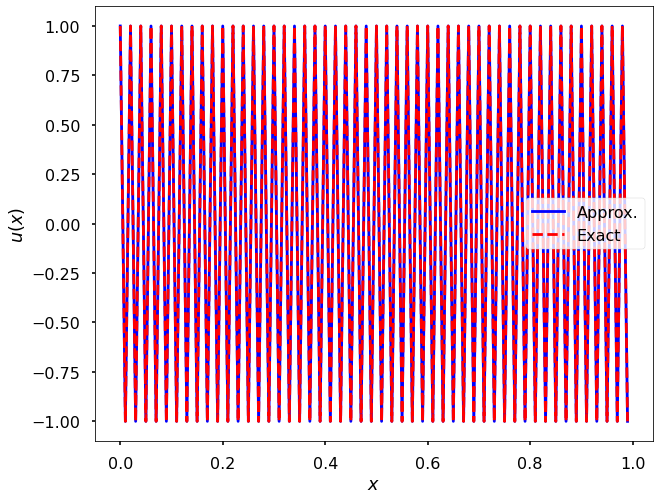

In [66]:
L = 1. # length of the computational interval
k = 1.5 # wavenumber
def distributed_load(x):
    return (2*np.pi*50)**2*np.cos(2*np.pi*50*x) -k**2*np.cos(2*np.pi*50*x)

# Discretization size
n = 100

# Compute numerical approximation and exact solution
uh, x = compute_fft(L, k, distributed_load, n)
uex, x =compute_exact(L, k, n)

# Plot the solution
plt.figure(figsize=(10,8))
plt.plot(x, uh, 'b-')
plt.plot(x, uex, 'r--')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend(['Approx.','Exact'])
plt.show()

We want to see how the error is decreasing as soon as $h=L/n$ tends to zero (or equivalently $n$ goes to $\infty$):

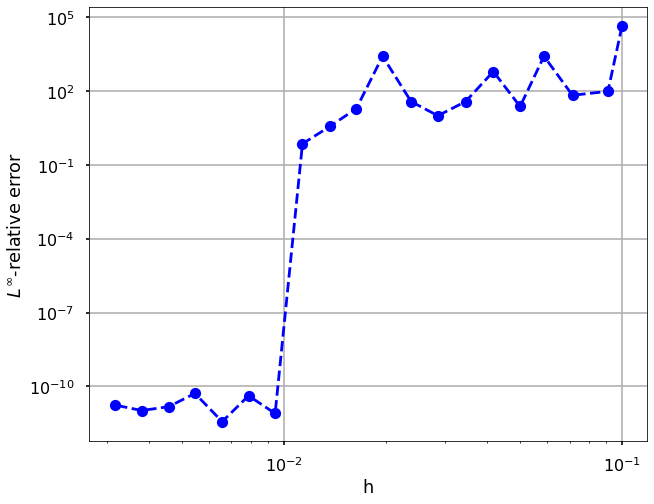

In [69]:
nvec = np.int_(np.logspace(1,2.5,20))
error = np.zeros(len(nvec))
for j,n in enumerate(nvec):
    uh, mesh = compute_fem(L, k, distributed_load, n)
    uex, mesh_ex = compute_exact(L, k, n)
    error[j] = np.linalg.norm(uh-uex,np.inf)/np.linalg.norm(uex,np.inf)
    
plt.figure(figsize = (10,8))
plt.loglog(L/nvec, error, 'bo--')
plt.xlabel('h')
plt.ylabel(r'$L^\infty$-relative error')
#plt.axis("square")
plt.grid()
plt.show()